In [1]:
library(tidyverse)
options(stringsAsFactors = F)
setwd("../../../Fetal_metaQTL/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Functions

In [2]:
fischer_ORA <- function(test_set, test_background, ref_set, ref_background, verbose = FALSE) {
    overlap = length(intersect(test_set, ref_set)) #q
    group1 = length(intersect(test_set, ref_background)) #k
    group2 = length(intersect(ref_set, test_background)) #m
    total = length(intersect(test_background, ref_background)) #t
    
    mat <- matrix(c(
        overlap, group1,
        group2, total
    ), nrow=2)
    rownames(mat) <- c("inRef", "!inRef")
    colnames(mat) <- c("inTest", "!inTest")
    
    if (verbose) {
         print(mat)
    }
    
    fischers_df <- data.frame()
    fischers_df[1,1] <- overlap #q
    fischers_df[2,1] <- group2 - overlap #k-q
    fischers_df[1,2] <- group1 - overlap #m-q
    fischers_df[2,2] <- total - group2 - group1 + overlap #t-m-k+q

    res <- fisher.test(fischers_df, alternative='greater')
    return(res)
}

# Data Loading

In [3]:
# Load in fetal-specific eGenes and all discovered fetal eGenes
tableS1 <- readxl::read_xlsx("data/manuscript/ST1.xlsx", sheet="ST1-2-eGene")
fetal_only_eGenes <- tableS1 %>% filter(fetal_only=="yes") %>% select(pid, gene_name, gene_type, qval) %>% as_tibble()
fetal_all_eGenes <- tableS1 %>% select(pid) %>% pull()

length(fetal_all_eGenes)
dim(fetal_only_eGenes)

[1] 10094

[1] 2488    4

In [4]:
# Load in Polioudakis cell markers
cell_markers <- read_csv("/u/project/gandalm/margolis/cindy-wgcna/module-overview/input/accessory_files/polioudakis_final_markers.csv")
cell_markers_bg <- unique(cell_markers$gene_id)
head(cell_markers)
unique(cell_markers$cell_type)
length(cell_markers_bg)

Rows: 7271 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): cell_type, gene_id, gene_name
dbl (5): log2_fold_change, p_value, fdr, percent_expressed_cluster, percent_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cell_type,gene_id,gene_name,log2_fold_change,p_value,fdr,percent_expressed_cluster,percent_expressed_all_cells
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ExN,ENSG00000171617,ENC1,1.1541568,0,0,73.3,55.2
ExN,ENSG00000124766,SOX4,0.8293880,0,0,88.1,80.1
ExN,ENSG00000134138,MEIS2,0.8190048,0,0,63.5,52.2
ExN,ENSG00000164600,NEUROD6,0.8169258,0,0,72.1,59.7
ExN,ENSG00000155926,SLA,0.7353093,0,0,63.9,52.5
ExN,ENSG00000092820,EZR,0.7151372,0,0,58.8,48.5


[1] "ExN" "NPC" "OPC" "END" "ExD" "PER" "MIC" "ExM" "INT"

[1] 3870

In [9]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al cluster (Table S4)
celltypemarkers_tableS4 <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5.xlsx', sheet='Cluster enriched genes') %>% as_tibble()
celltypemarkers_tableS4 <- janitor::clean_names(celltypemarkers_tableS4)
celltypemarkers_tableS4_bg <- unique(celltypemarkers_tableS4$ensembl)
head(celltypemarkers_tableS4)
dim(celltypemarkers_tableS4)
unique(celltypemarkers_tableS4$cluster)
length(celltypemarkers_tableS4_bg)

ensembl,gene,cluster,log2_fold_change,p_value,fdr,percent_expressed_cluster,percent_expressed_all_cells
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000171617,ENC1,ExN,1.15415684851705,0,0,73.3,55.2
ENSG00000124766,SOX4,ExN,0.829387981626601,0,0,88.1,80.1
ENSG00000134138,MEIS2,ExN,0.81900483848292,0,0,63.5,52.2
ENSG00000164600,NEUROD6,ExN,0.816925751244978,0,0,72.1,59.7
ENSG00000155926,SLA,ExN,0.735309292588594,0,0,63.9,52.5
ENSG00000092820,EZR,ExN,0.715137175304713,0,0,58.8,48.5


[1] 7271    8

[1] "ExN"   "PgG2M" "OPC"   "End"   "ExDp2" "Per"   "Mic"   "ExM"   "IP"   
[10] "ExDp1" "ExM-U" "InMGE" "InCGE" "oRG"   "PgS"   "vRG"

[1] 3870

In [10]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al subcluster (Table S5)
celltypemarkers_tableS5 <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
celltypemarkers_tableS5 <- janitor::clean_names(celltypemarkers_tableS5)
celltypemarkers_tableS5_bg <- unique(celltypemarkers_tableS5$ensembl)
head(celltypemarkers_tableS5)
dim(celltypemarkers_tableS5)
unique(celltypemarkers_tableS5$cluster)
length(celltypemarkers_tableS5_bg)

cluster,subcluster,gene,ensembl,log2_fold_change,pvalue,fdr,percent_cluster,percent_all
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
vRG,vRG_0,NPY,ENSG00000122585,0.942790163299949,2.57709368277351e-36,1.07928683434554e-32,51.8,24.8
vRG,vRG_0,LGALS3,ENSG00000131981,0.733201099417694,3.03296906500458e-32,4.2340248147464e-29,50,24.4
vRG,vRG_0,NNAT,ENSG00000053438,0.812606413056216,7.79412721754092e-19,6.52836095741227e-16,83,64.5
vRG,vRG_0,SLC1A2,ENSG00000110436,0.384165785170468,3.04015437301369e-17,1.59152081427267e-14,27.2,12.9
vRG,vRG_0,SLCO1C1,ENSG00000139155,0.360802531568306,3.99551060019108e-17,1.75033287840493e-14,27.2,13.1
vRG,vRG_0,KIF5C,ENSG00000168280,0.578180352908194,1.9842717843625e-16,7.55466384810012e-14,56.2,37.3


[1] 10604     9

[1] "vRG"   "oRG"   "PgS"   "PgG2M" "IP"    "ExN"   "ExM"   "ExM-U" "ExDp1"
[10] "ExDp2" "InMGE" "InCGE" "OPC"   "End"   "Per"

[1] 4074

# Analysis

## GO Analysis

In [19]:
# Run gene ontology on fetal-only eGenes
go_genes <- fetal_only_eGenes %>%
                select(pid) %>%
                pull

# Non-ordered GO query with custom background of all fetal eGenes
gostres <- gprofiler2::gost(query = go_genes,
                custom_bg = fetal_all_eGenes,
                organism = "hsapiens",
                ordered_query = FALSE,
                significant = FALSE)
go_tbl <- gostres$result
quick_res <- go_tbl %>%
                select(source, p_value, term_id)

# Take the top results for important categories
top_terms <- quick_res %>%
                filter(source %in% c("GO:BP","GO:MF","GO:CC","KEGG","REAC")) %>%
                group_by(source) %>%
                arrange(p_value) %>%
                slice(1:3) %>%
                ungroup %>%
                arrange(p_value) %>%
                select(term_id) %>%
                pull

Detected custom background input, domain scope is set to 'custom'



png 
  2

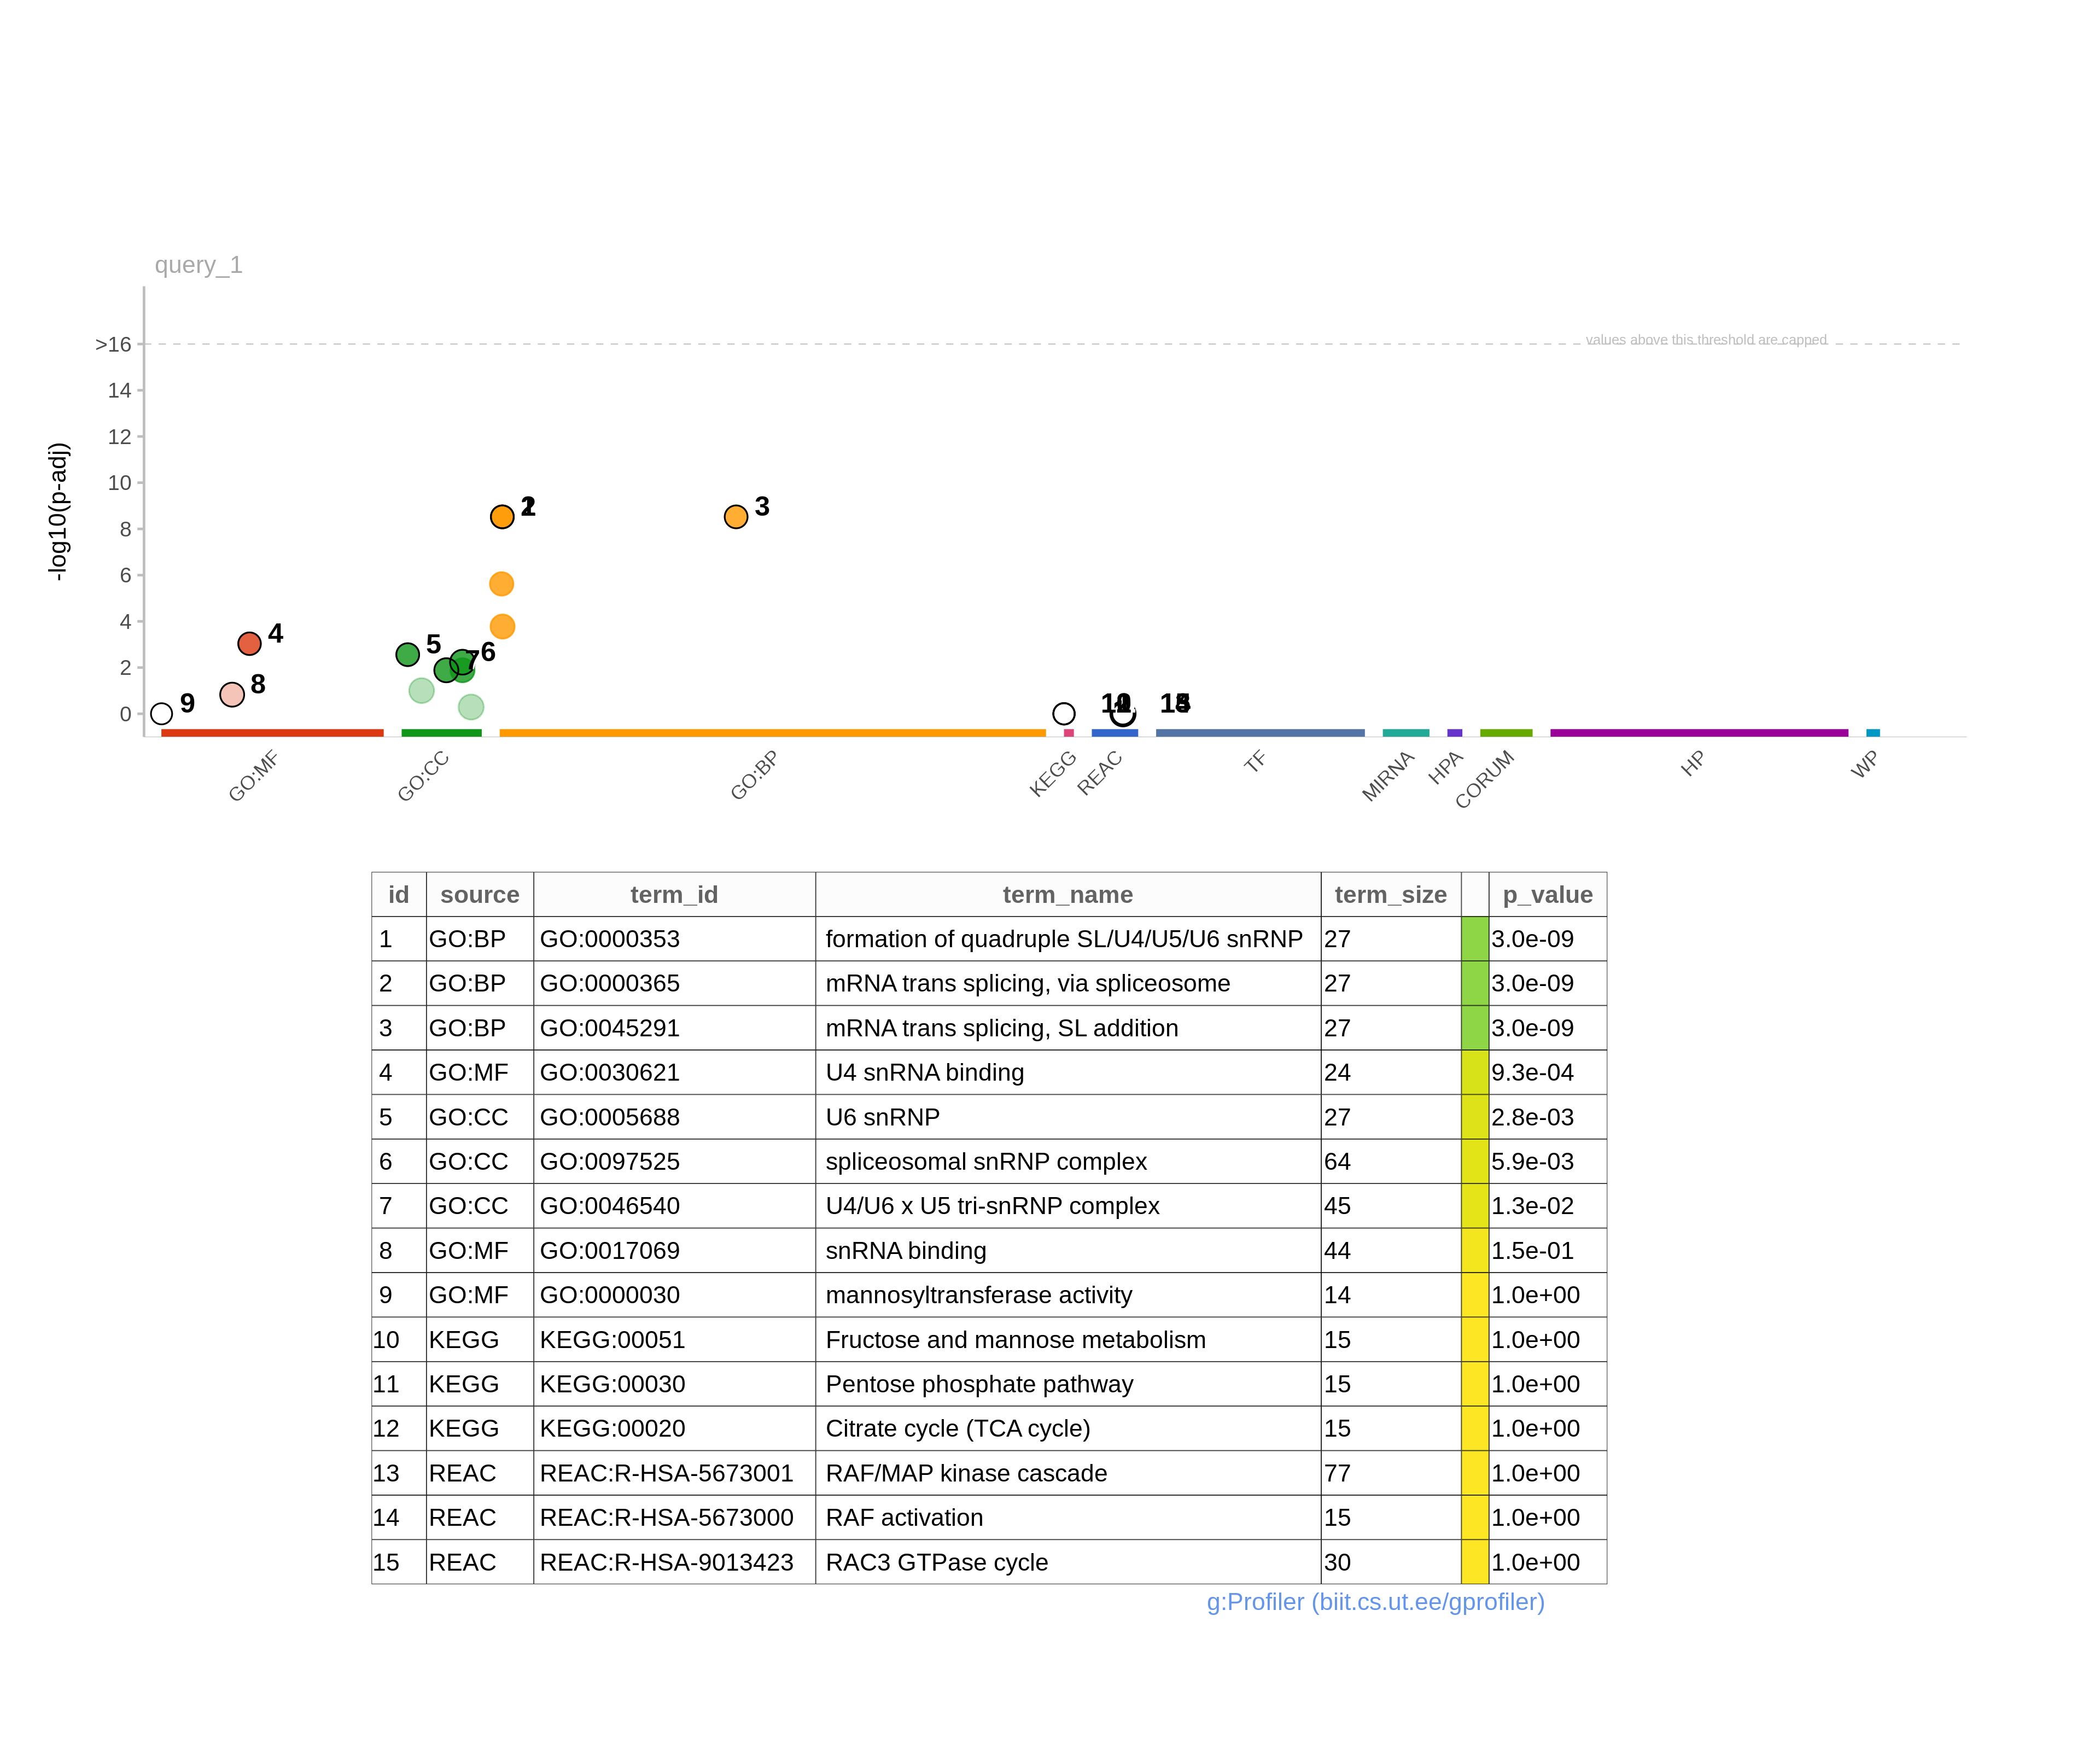

In [20]:
# Custom plot options
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 320)

# The gplot function automatically plots the results, suppress that with file=NULL
pdf(file = NULL)
gplot <- gprofiler2::gostplot(gostres, capped = TRUE, interactive = FALSE)
pubplot <- gprofiler2::publish_gostplot(gplot, highlight_terms = top_terms) + theme(plot.margin = margin(t = 100, r = 50, b = 50, l = 0, unit = "pt"))
dev.off()

# Plot the results with highlights
pubplot

## Cell Type Analysis

In [11]:
fetal_only_egenes_cell_res <- tibble()

for (cell in unique(cell_markers$cell_type)) {
    cat(paste0(cell, " "))
    
    one_cell_markers <- cell_markers %>%
                            filter(cell_type == cell) %>%
                            select(gene_id) %>%
                            pull
    
    res <- fischer_ORA(test_set = fetal_only_eGenes$pid,
                       test_background = fetal_all_eGenes,
                       ref_set = one_cell_markers,
                       ref_background = cell_markers_bg)
    
    fetal_only_egenes_cell_res <- rbind(fetal_only_egenes_cell_res, tibble(scenario = "fetal_only_egenes",
                                                                       cell_type = cell,
                                                                       fischer_p = res$p.value,
                                                                       fischer_or = as.numeric(res$estimate)))
}

fetal_only_egenes_cell_res %>% arrange(cell_type)

ExN NPC OPC END ExD PER MIC ExM INT 

scenario,cell_type,fischer_p,fischer_or
<chr>,<chr>,<dbl>,<dbl>
fetal_only_egenes,END,0.07814424,1.4114968
fetal_only_egenes,ExD,0.77014122,0.8781365
fetal_only_egenes,ExM,0.52017771,1.0204054
fetal_only_egenes,ExN,0.04049335,1.7085804
fetal_only_egenes,INT,0.47834312,1.0836420
fetal_only_egenes,MIC,0.50314031,1.0185644
fetal_only_egenes,NPC,0.17006525,1.1966047
fetal_only_egenes,OPC,0.35010063,1.1283830
fetal_only_egenes,PER,0.89483311,0.7894308


In [12]:
fetal_only_egenes_cell_cluster_res <- tibble()

for (cell in unique(celltypemarkers_tableS4$cluster)) {
    cat(paste0(cell, " "))
    
    one_cell_markers <- celltypemarkers_tableS4 %>%
                            filter(cluster == cell) %>%
                            select(ensembl) %>%
                            pull
    
    res <- fischer_ORA(test_set = fetal_only_eGenes$pid,
                       test_background = fetal_all_eGenes,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS4_bg)
    
    fetal_only_egenes_cell_cluster_res <- rbind(fetal_only_egenes_cell_cluster_res, tibble(scenario = "fetal_only_egenes",
                                                                                   cell_type = cell,
                                                                                   fischer_p = res$p.value,
                                                                                   fischer_or = as.numeric(res$estimate)))
}

fetal_only_egenes_cell_cluster_res %>% arrange(fischer_p)

ExN PgG2M OPC End ExDp2 Per Mic ExM IP ExDp1 ExM-U InMGE InCGE oRG PgS vRG 

scenario,cell_type,fischer_p,fischer_or
<chr>,<chr>,<dbl>,<dbl>
fetal_only_egenes,ExN,0.01746361,3.1464929
fetal_only_egenes,PgG2M,0.03192497,1.6060186
fetal_only_egenes,End,0.07814424,1.4114968
fetal_only_egenes,PgS,0.21029986,1.2192021
fetal_only_egenes,IP,0.22340122,1.3304898
fetal_only_egenes,OPC,0.35010063,1.1283830
fetal_only_egenes,InCGE,0.35850537,1.2826509
fetal_only_egenes,ExM,0.38197734,1.1819303
fetal_only_egenes,vRG,0.47080726,1.0448987


In [13]:
fetal_only_egenes_cell_subtype_res <- tibble()

for (cell in unique(celltypemarkers_tableS5$subcluster)) {
    cat(paste0(cell, " "))
    
    one_cell_markers <- celltypemarkers_tableS5 %>%
                            filter(subcluster == cell) %>%
                            select(ensembl) %>%
                            pull
    
    res <- fischer_ORA(test_set = fetal_only_eGenes$pid,
                       test_background = fetal_all_eGenes,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS5_bg)
    
    fetal_only_egenes_cell_subtype_res <- rbind(fetal_only_egenes_cell_subtype_res, tibble(scenario = "fetal_only_egenes",
                                                                                   cell_type = cell,
                                                                                   fischer_p = res$p.value,
                                                                                   fischer_or = as.numeric(res$estimate)))
}

fetal_only_egenes_cell_subtype_res %>% arrange(fischer_p)

vRG_0 vRG_1 vRG_2 vRG_3 oRG_0 oRG_1 oRG_2 oRG_3 oRG_4 PgS_0 PgS_1 PgS_2 PgS_3 PgS_4 PgG2M_0 PgG2M_1 PgG2M_2 PgG2M_3 PgG2M_4 IP_0 IP_1 IP_2 IP_3 ExN_0 ExN_1 ExN_2 ExN_4 ExN_5 ExN_6 ExN_7 ExM_0 ExM_2 ExM_3 ExM_4 ExM_5 ExM_6 ExM_7 ExM-U_0 ExM-U_1 ExM-U_2 ExM-U_3 ExM-U_4 ExM-U_5 ExDp1_0 ExDp1_1 ExDp1_2 ExDp1_3 ExDp2_1 InMGE_0 InMGE_1 InMGE_2 InMGE_3 InMGE_4 InMGE_6 InMGE_7 InCGE_0 InCGE_1 InCGE_2 InCGE_3 InCGE_4 InCGE_5 OPC_0 OPC_1 OPC_2 OPC_3 OPC_4 OPC_5 End_1 End_2 Per_0 Per_1 Per_2 

scenario,cell_type,fischer_p,fischer_or
<chr>,<chr>,<dbl>,<dbl>
fetal_only_egenes,vRG_0,0.001109042,3.293956
fetal_only_egenes,PgS_0,0.006811798,4.000788
fetal_only_egenes,ExN_1,0.027275602,3.680192
fetal_only_egenes,IP_1,0.038674920,2.124972
fetal_only_egenes,End_2,0.050597267,2.006989
fetal_only_egenes,PgS_3,0.051036457,1.625594
fetal_only_egenes,OPC_5,0.051275475,1.585318
fetal_only_egenes,PgG2M_4,0.070785368,2.037140
fetal_only_egenes,End_1,0.071954870,1.439782


## Biotype Analysis

In [160]:
fetal_only_biotype_df <- fetal_only_eGenes %>% count(gene_type) %>% filter(n > 10)
fetal_only_biotype_df

gene_type,n
<chr>,<int>
lncRNA,1069
miRNA,55
misc_RNA,67
processed_pseudogene,198
protein_coding,737
snoRNA,67
snRNA,35
TEC,103
transcribed_processed_pseudogene,24


In [161]:
fetal_only_biotype_df <- fetal_only_biotype_df %>% mutate(prop = n/sum(n))
fetal_only_biotype_df

gene_type,n,prop
<chr>,<int>,<dbl>
lncRNA,1069,0.435970636
miRNA,55,0.022430669
misc_RNA,67,0.027324633
processed_pseudogene,198,0.080750408
protein_coding,737,0.300570962
snoRNA,67,0.027324633
snRNA,35,0.014274062
TEC,103,0.042006525
transcribed_processed_pseudogene,24,0.009787928


# Final Figure Plots

In [25]:
fetal_egene_corr_plot_tbl <- fetal_only_egenes_cell_cluster_res %>%
                            mutate(fisher_fdr = p.adjust(fischer_p, "fdr")) %>%
                            mutate(fisher_fdr_log = -log10(fisher_fdr)) %>% 
                            arrange(fisher_fdr) %>%
                            pivot_wider(id_cols = cell_type,
                                        names_from = scenario,
                                        values_from = fisher_fdr_log) %>%
                            column_to_rownames("cell_type")

Warning message in corrplot::corrplot(as.matrix(fetal_egene_corr_plot_tbl), method = "square", :
“col.lim interval too wide, please set a suitable value”


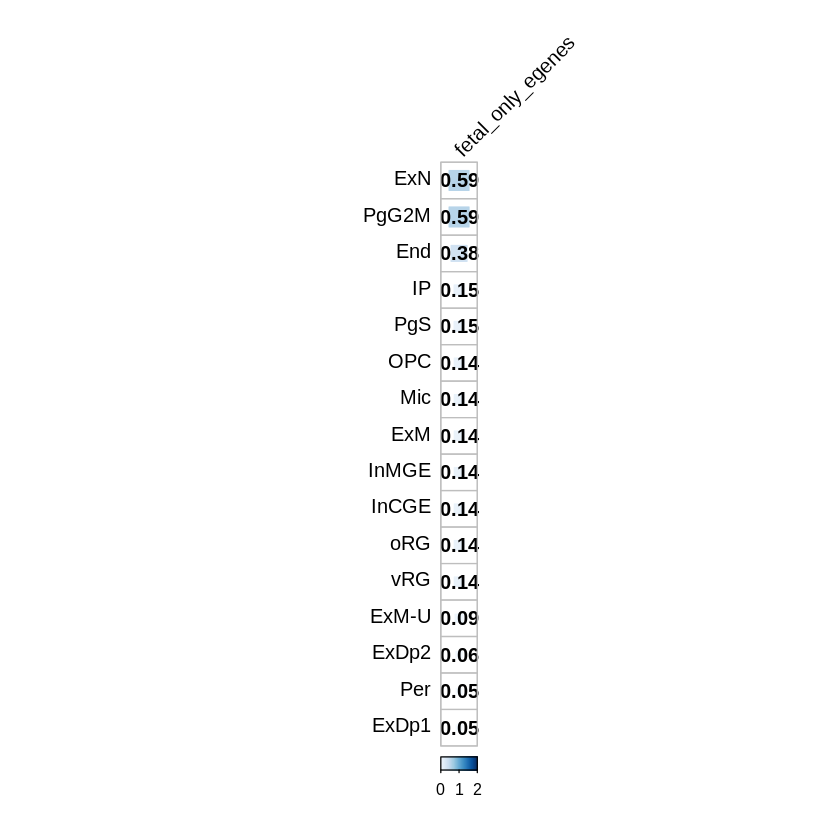

In [26]:
corrplot::corrplot(as.matrix(fetal_egene_corr_plot_tbl), method = 'square', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.ratio = 0.1, cl.pos = 'b', cl.length = 3,
            tl.col = 'black', tl.srt = 45,
            col = corrplot::COL1('Blues', 200), col.lim=c(0, 2), addCoef.col ='black')

In [37]:
fetal_egene_plot_tbl <- fetal_only_egenes_cell_subtype_res %>%
                            mutate(fisher_fdr = p.adjust(fischer_p, "fdr")) %>%
                            mutate(fisher_fdr_log = -log10(fisher_fdr)) %>% 
                            arrange(cell_type) %>%
                            mutate(class = case_when(
                                grepl("Ex", cell_type) ~ "Excitatory Neurons",
                                grepl("In", cell_type) ~ "Interneurons",
                                grepl("Mic|Per|End", cell_type) ~ "Other",
                                TRUE ~ "Progenitors"
                            ))

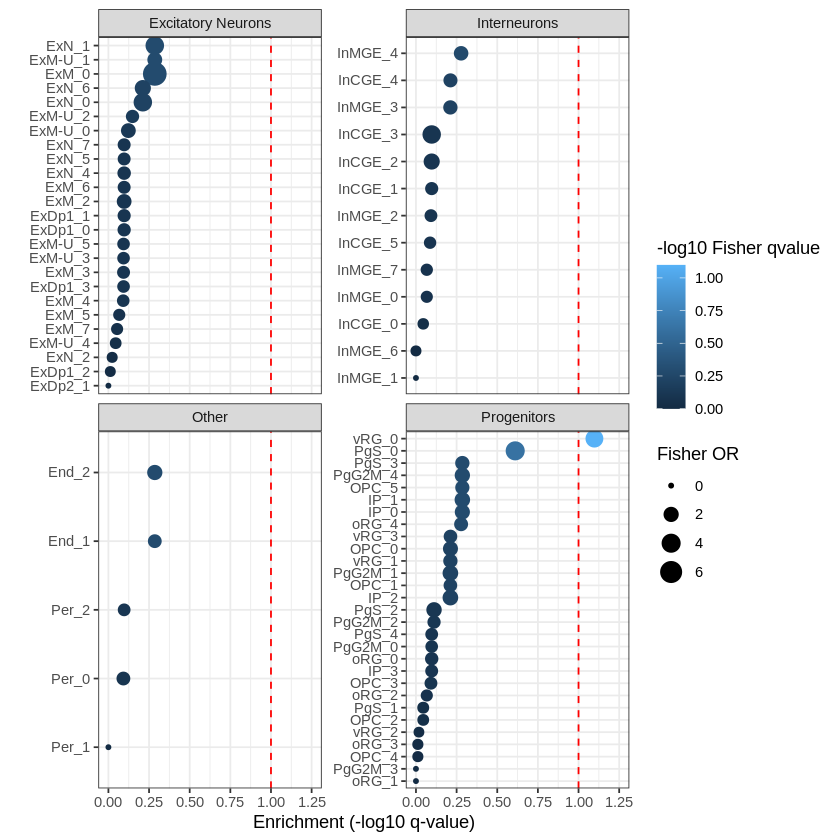

In [38]:
cell_plot <- ggplot(fetal_egene_plot_tbl, aes(
        x = reorder(cell_type, -fisher_fdr),
        y = -log10(fisher_fdr),
        size = fischer_or,
        color = -log10(fisher_fdr))) +
    geom_point() + coord_flip() + facet_wrap(~class, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = 1,lty=2,color='red') + labs(y='Enrichment (-log10 q-value)', x='') + 
    theme(plot.title = element_text(hjust=.5)) +
    labs(size = "Fisher OR", color = "-log10 Fisher qvalue") + scale_y_continuous(limits = c(0, 1.25), breaks = seq(0,1.25,0.25))

cell_plot

In [203]:
fetal_only_biotype_plot_df <- fetal_only_biotype_df %>%
                              mutate(gene_type = gsub("_", "\n", gene_type))

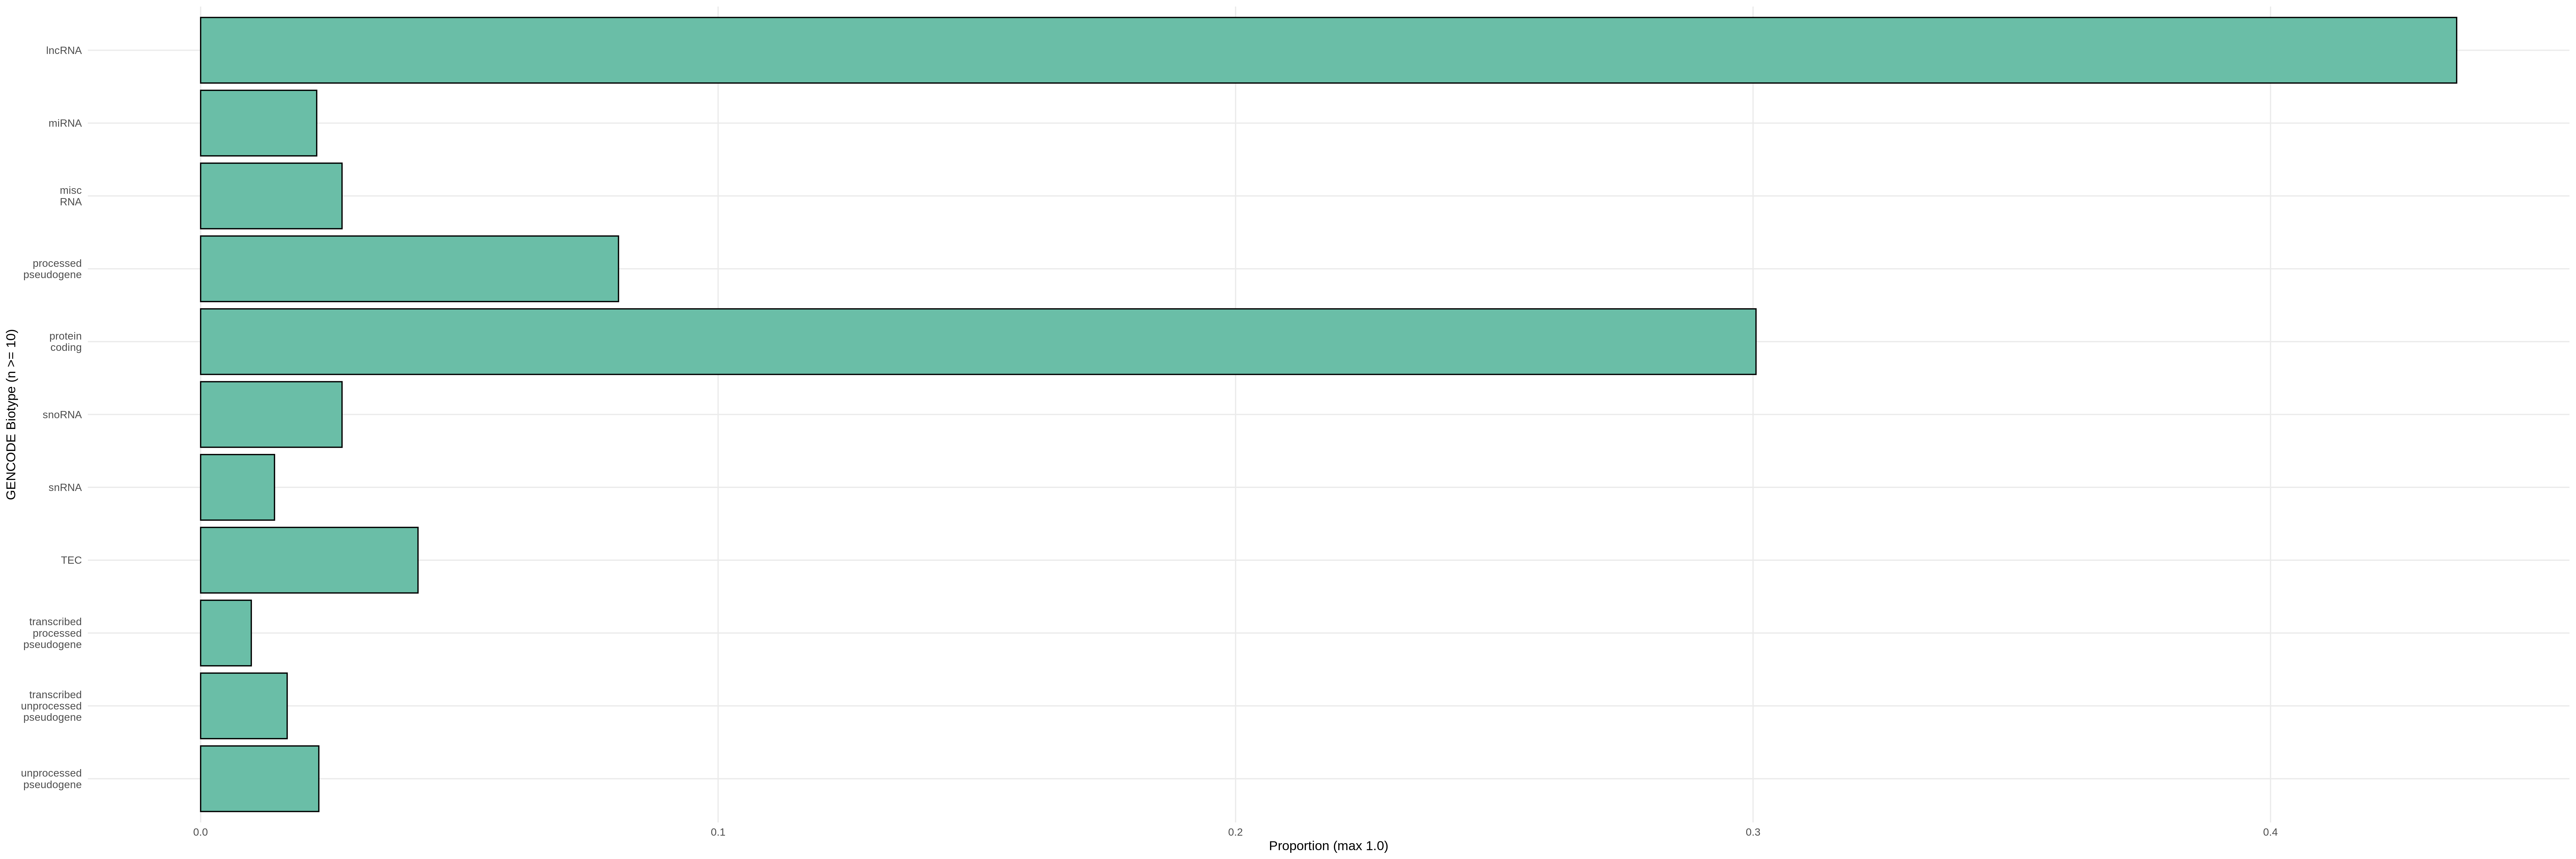

In [204]:
biotype_plot <- ggplot(data = fetal_only_biotype_plot_df, aes(x = prop, y = fct_rev(gene_type))) +
    geom_bar(stat="identity", color="black", position=position_dodge2(padding = 0, reverse = TRUE), fill = "#6ABEA7") +
    xlab("Proportion (max 1.0)") + ylab("GENCODE Biotype (n >= 10)") +
    theme_minimal() +
    theme(panel.grid.minor = element_blank(),
          panel.background = element_blank())

biotype_plot

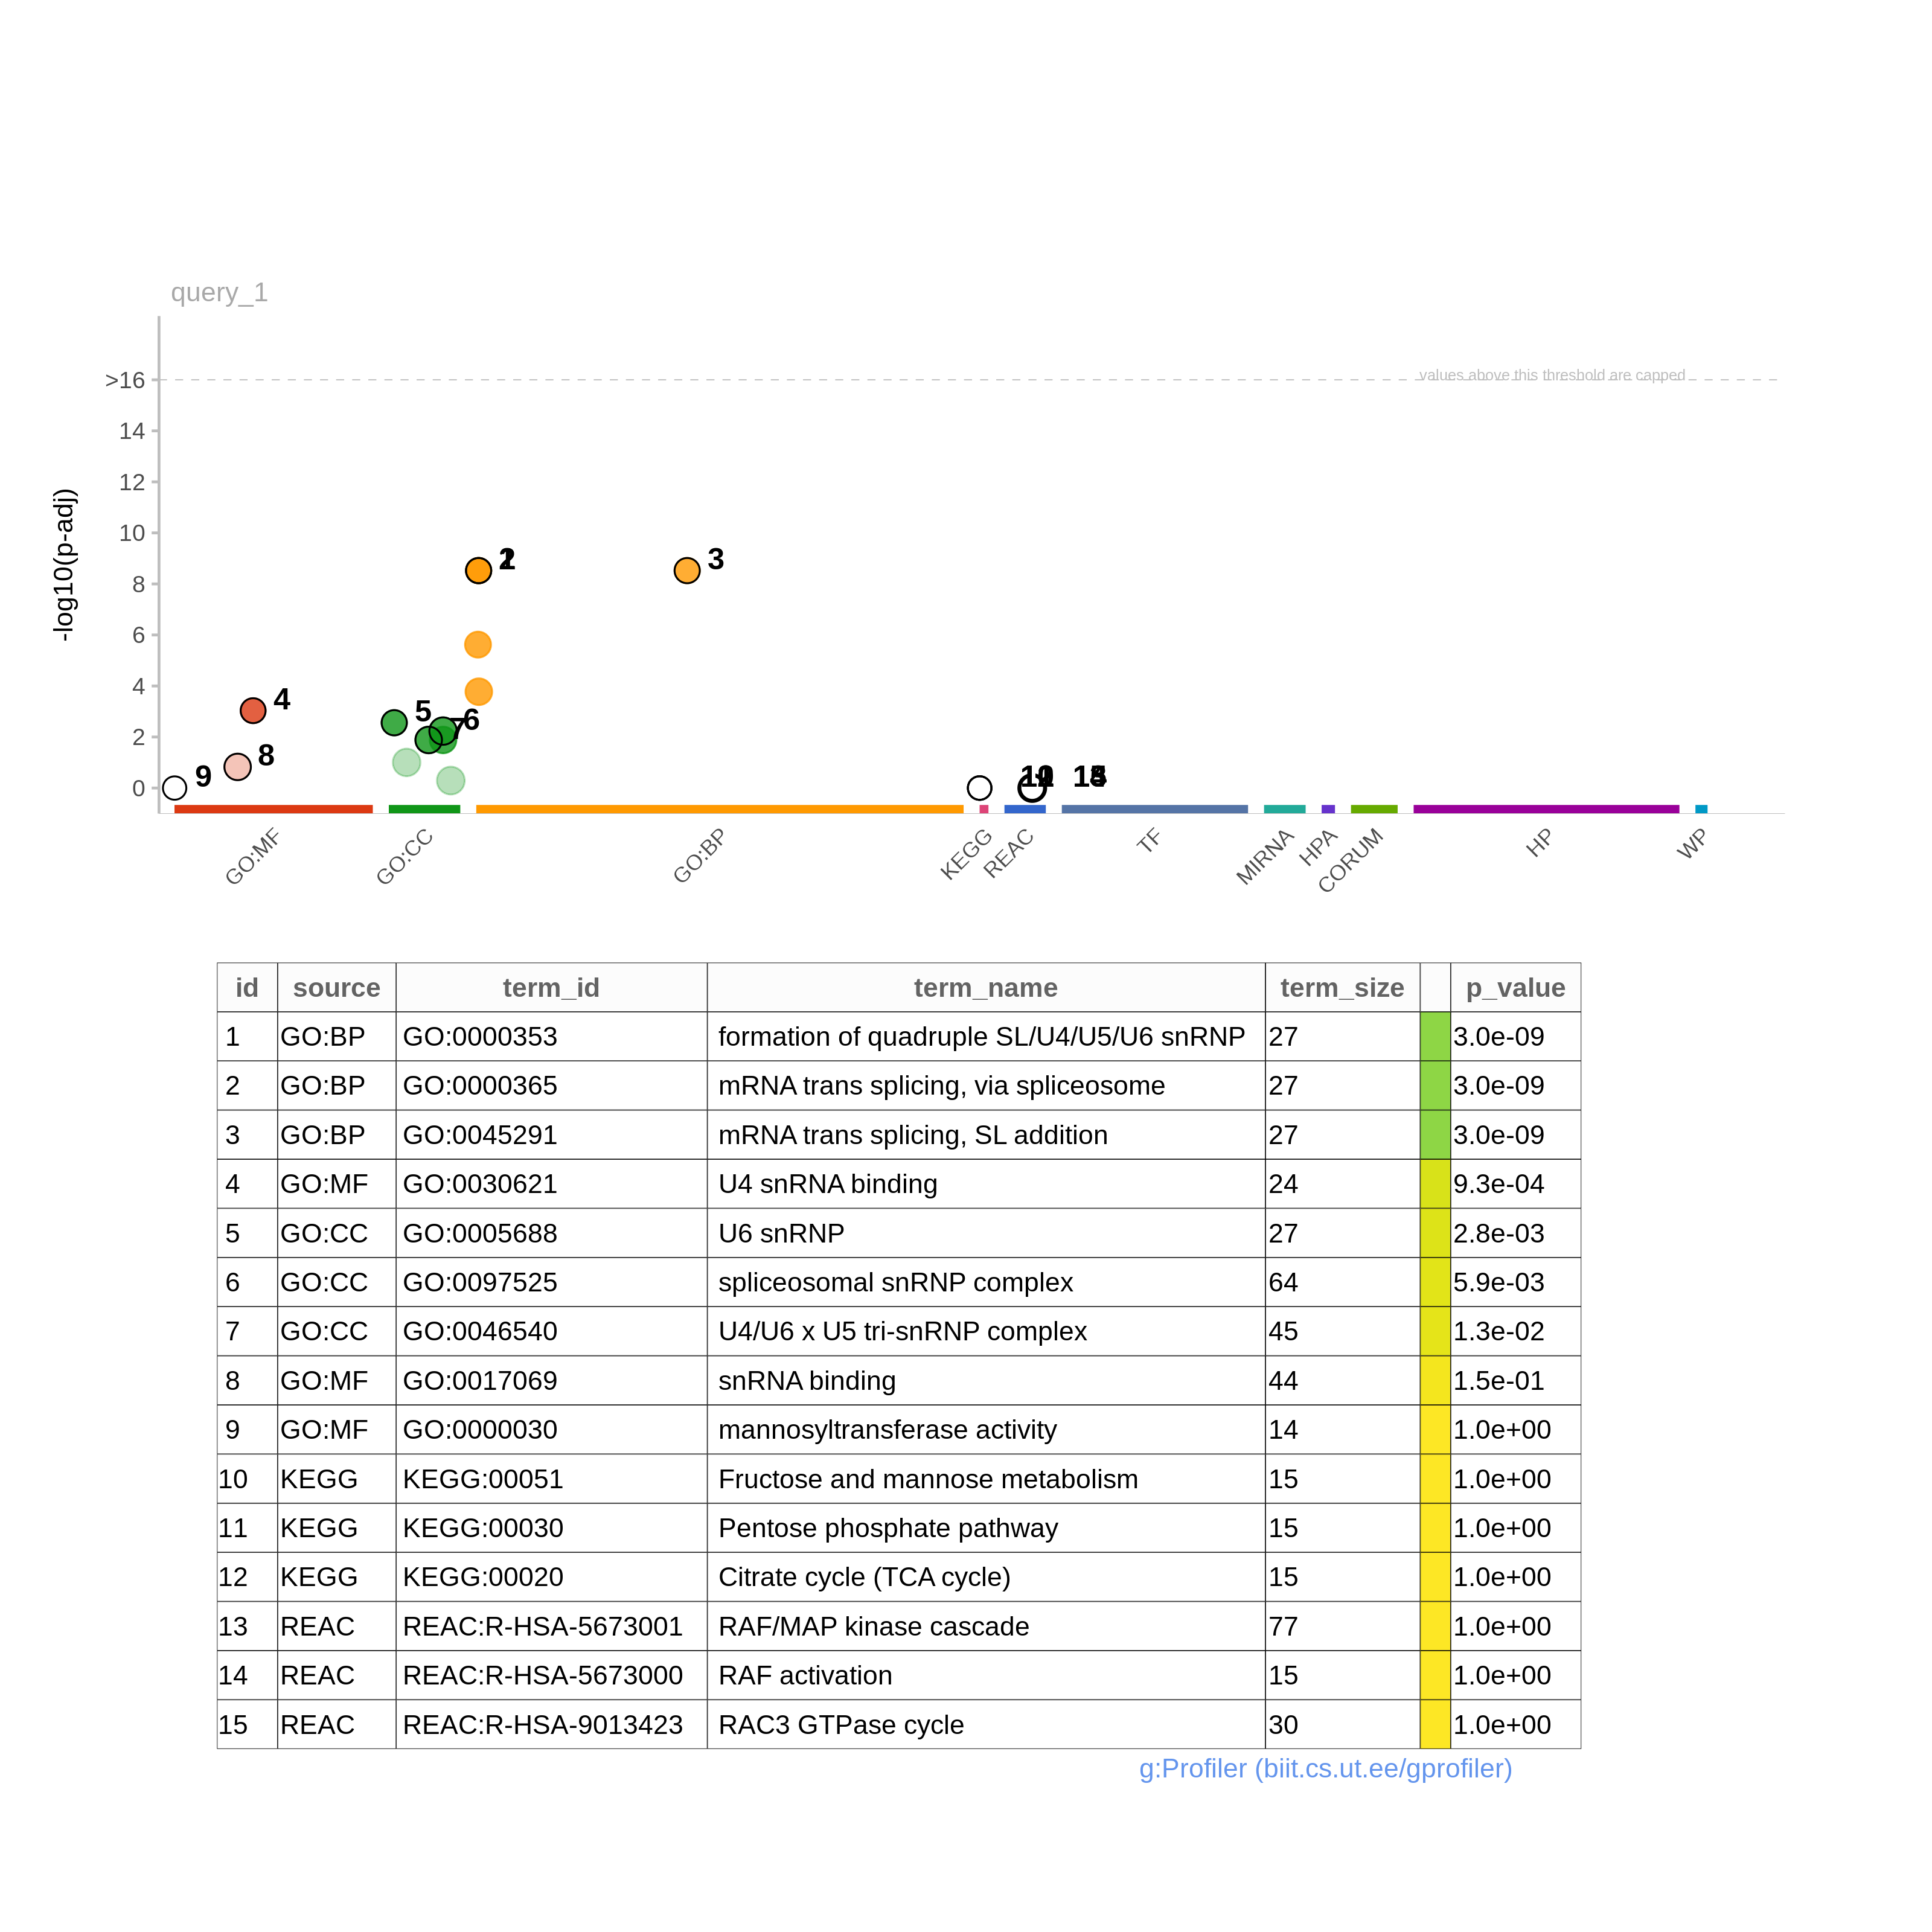

In [182]:
pubplot

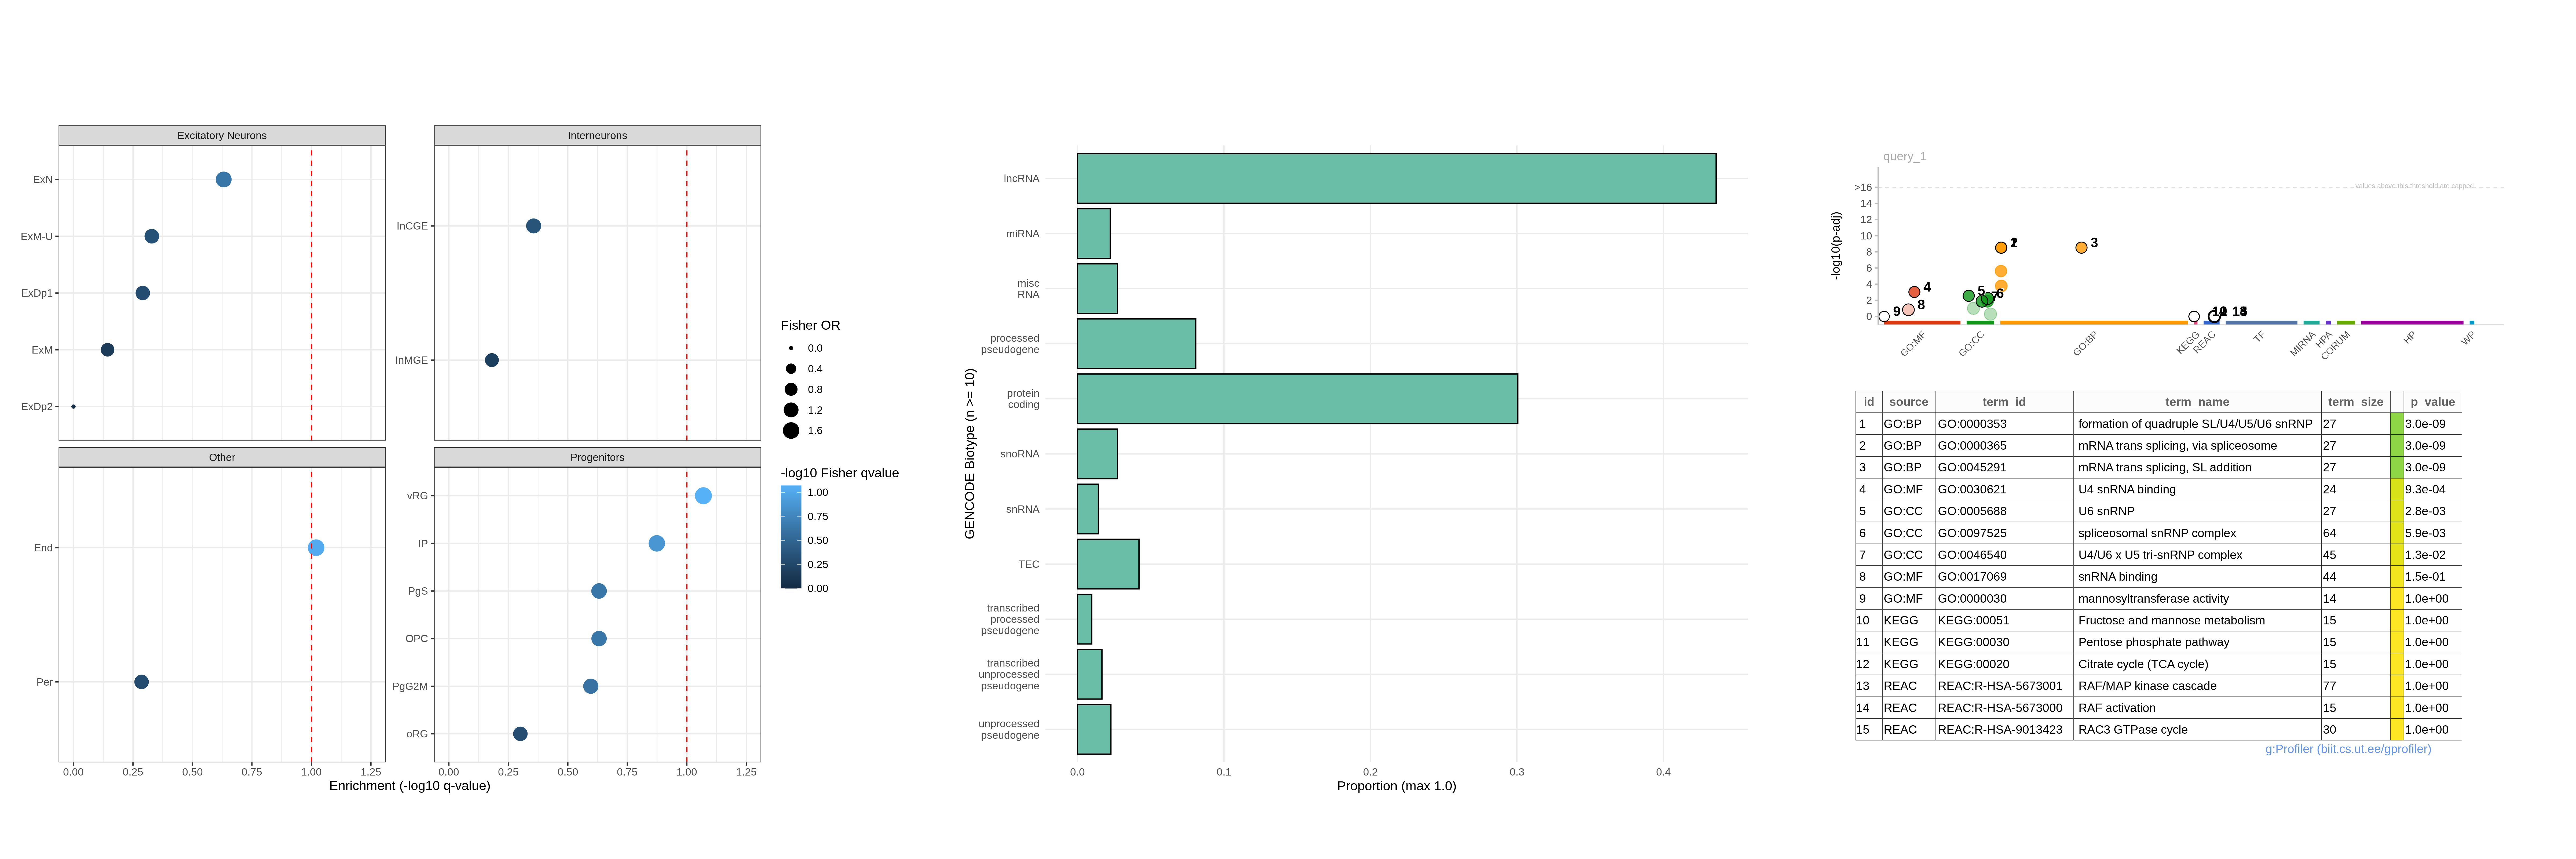

In [205]:
# Custom plot options
options(repr.plot.width = 30, repr.plot.height = 10, repr.plot.res = 320)
library(patchwork)

patch_plot <- cell_plot + theme(plot.margin = unit(c(0,50,0,0), "pt")) +
              biotype_plot + theme(plot.margin = unit(c(0,50,0,0), "pt")) +
              pubplot

patch_plot

# Save Plots

In [206]:
ggsave(filename = "~/projects/cindy-wgcna/publication/figures/SF3/SF3_full_plot.pdf", plot = patch_plot, device = "pdf", width = 30, height = 10)